In [1]:
###
### Start again from here
###

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

In [2]:
### Define and test L_to_spec_str functions
L = 4
print(f'L={L}')

def L_to_spec_str_constant():
    return '.'
print(f'L_to_spec_str_constant(): "{L_to_spec_str_constant()}"')

def L_to_spec_str_additive(L):
    parts = []
    parts.append(L_to_spec_str_constant())
    for i in range(L):
        parts.append(f'{i:d}')
    return '+'.join(parts)
print(f'L_to_spec_str_additive(L={L}): "{L_to_spec_str_additive(L=L)}"')

def L_to_spec_str_neighbor(L):
    parts = []
    parts.append(L_to_spec_str_additive(L))
    for i in range(L-1):
        parts.append(f'{i:d}x{i+1:d}')
    return '+'.join(parts)
print(f'L_to_spec_str_neighbor(L={L}): "{L_to_spec_str_neighbor(L=L)}"')

def L_to_spec_str_pairwise(L):
    parts = []
    parts.append(L_to_spec_str_additive(L))
    for i in range(L-1):
        for j in range(i+1,L):
            parts.append(f'{i:d}x{j:d}')
    return '+'.join(parts)
print(f'L_to_spec_str_pairwise(L={L}): "{L_to_spec_str_pairwise(L=L)}"')

def L_to_spec_str_3adjacent(L):
    parts = []
    parts.append(L_to_spec_str_neighbor(L))
    for i in range(L-2):
        parts.append(f'{i:d}x{i+1:d}x{i+2}')
    return '+'.join(parts)
print(f'L_to_spec_str_3adjacent(L={L}): "{L_to_spec_str_3adjacent(L=L)}"')

def L_to_spec_str_3order(L):
    parts = []
    parts.append(L_to_spec_str_pairwise(L))
    for i in range(L-2):
        for j in range(i+1,L-1):
            for k in range(j+1,L):
                parts.append(f'{i:d}x{j:d}x{k:d}')
    return '+'.join(parts)
print(f'L_to_spec_str_3order(L={L}): "{L_to_spec_str_3order(L=L)}"')


L=4
L_to_spec_str_constant(): "."
L_to_spec_str_additive(L=4): ".+0+1+2+3"
L_to_spec_str_neighbor(L=4): ".+0+1+2+3+0x1+1x2+2x3"
L_to_spec_str_pairwise(L=4): ".+0+1+2+3+0x1+0x2+0x3+1x2+1x3+2x3"
L_to_spec_str_3adjacent(L=4): ".+0+1+2+3+0x1+1x2+2x3+0x1x2+1x2x3"
L_to_spec_str_3order(L=4): ".+0+1+2+3+0x1+0x2+0x3+1x2+1x3+2x3+0x1x2+0x1x3+0x2x3+1x2x3"


In [3]:
### Define and test seq_to_x function
x_triv = np.array([1])
x_ohe_A = np.array([1, 0, 0, 0])
x_ohe_C = np.array([0, 1, 0, 0])
x_ohe_G = np.array([0, 0, 1, 0])
x_ohe_T = np.array([0, 0, 0, 1])

char_to_ohe_dict = {
    'A':x_ohe_A,
    'C':x_ohe_C,
    'G':x_ohe_G,
    'T':x_ohe_T
}

def seq_to_x(seq, ohe_spec_str):
    '''
    inputs: seq (DNA), ohe_spec_str
    returns: x, a one-hot encoding
    '''
    L = len(seq)
    x_components = []
    
    ohe_spec_str_parts = ohe_spec_str.split('+')
    for part in ohe_spec_str_parts:
        
        # Add in trivial component
        if part=='.':
            x_components.append(x_triv)
        else:
            positions = [int(p) for p in part.split('x')]
            assert len(positions) > 0
            x_irr = x_triv
            while len(positions) > 0:
                pos = positions.pop(-1)
                c = seq[pos]
                x_l = char_to_ohe_dict[c]
                x_irr = np.kron(x_irr, x_l)
            x_components.append(x_irr)
    
    # Create x
    x = np.concatenate(x_components)
    return x

# Test seq_to_x_neighbor
seq = 'AA'
L = len(seq)
ohe_spec_str = L_to_spec_str_neighbor(L)
x = seq_to_x(seq, ohe_spec_str)
print('M:', len(x))
print('ohe_spec_str:', ohe_spec_str)
print('x: ', x)

M: 25
ohe_spec_str: .+0+1+0x1
x:  [1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


<25x25 sparse matrix of type '<class 'numpy.float64'>'
	with 289 stored elements in Compressed Sparse Row format>

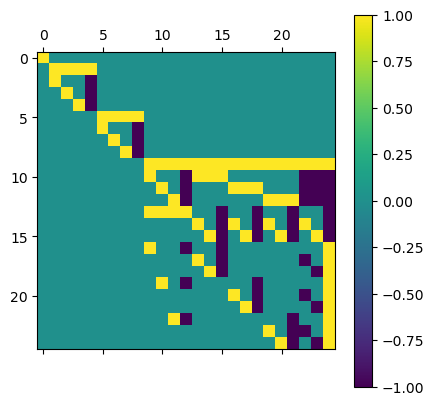

In [4]:
### Define and test _ohe_spec_to_T function

# Trivial matrix
T_triv = sp.csr_array([[1]])

# ohe_to_block for single position
T_ohe = sp.csr_array([
    [1, 1, 1, 1],
    [1, 0, 0, -1],
    [0, 1, 0, -1],
    [0, 0, 1, -1]
])
T_ohe_inv = sp.csr_matrix(np.linalg.inv(T_ohe.todense()))

alpha = 4
import pdb
def _ohe_spec_to_T(ohe_spec_str):
    '''
    input: ohe_spec_str
    output: T (s.t. T x = x_factored)
    '''
    parts = ohe_spec_str.split('+')
    diag_mats = []
    diag_mats_inv = []
    for part in parts:
        if part == '.':
            T_part = T_triv
            T_part_inv = T_triv
        else:
            bits = part.split('x')
            T_part = T_triv
            T_part_inv = T_triv
            for bit in part.split('x'):
                alpha = T_ohe.shape[0]
                m = T_part.shape[0]

                # Compute kronecker product
                T_part = sp.kron(T_part, T_ohe)
                T_part_inv = sp.kron(T_ohe_inv,T_part_inv)

                # Fix up row orderd (# Is this where this goes?)
                i_vals = list(range(m*alpha))
                j_vals = [alpha*i for i in range(m)] + [i-m+1+(i-m)//(alpha-1) for i in range(m,m*alpha)]
                data = m*alpha*[1]
                B = sp.coo_array((data, (i_vals, j_vals)), shape=(alpha*m,alpha*m)).tocsr()
                #pdb.set_trace()
                T_part = B@T_part@(B.T)
                T_part_inv = B@T_part_inv@(B.T)
        diag_mats.append(T_part)
        diag_mats_inv.append(T_part_inv)
    T = sp.block_diag(diag_mats, format='csr')
    T_inv = sp.block_diag(diag_mats_inv, format='csr')
    return T, T_inv

# Test ohe_spec_str_to_T
T, T_inv = _ohe_spec_to_T(ohe_spec_str)
plt.matshow(T.todense())
plt.colorbar()
T_inv

In [5]:
def my_expand(x):
    """
    Expands a list of lists. Simulates product expansion
    """
    if len(x) >= 1:
        a = x[0]
        b = x[1:]
        b_exp = my_expand(b)
        c = [[y]+z for y in a for z in b_exp]        
        return c
    else:
        return [x]

my_expand([['0', '1', '3'], ['4','5'], ['6']])

[['0', '4', '6'],
 ['0', '5', '6'],
 ['1', '4', '6'],
 ['1', '5', '6'],
 ['3', '4', '6'],
 ['3', '5', '6']]

In [40]:
### Convert OHE to SIM spec
def ohe_to_sim_spec(ohe_spec_str):
    a = ohe_spec_str.split('+')
    b = [z.split('x') for z in a]
    for i in range(len(b)):
        for j in range(len(b[i])):
            z = b[i][j]
            if z!='.':
                b[i][j]=['.',z]
    
    # Recursive expansion
    c = []
    for i, b_el in enumerate(b):
        if isinstance(b_el, str):
            c.append([b_el])
        elif isinstance(b_el, list) and len(b_el)>=1:
            c.extend(my_expand(b_el))

    # Remove redundant factors of '.'
    sim_spec_list = []
    for x in c:
        y = [z for z in x if z!='.']
        if len(y)==0:
            y = ['.']
        sim_spec_list.append(y)
    sim_spec_str = '+'.join(['x'.join(z) for z in sim_spec_list])
    return sim_spec_str

# Test expansion
sim_spec_str = ohe_to_sim_spec(ohe_spec_str)
print(f'ohe_spec_str: "{ohe_spec_str}"')
print(f'sim_spec_str: "{sim_spec_str}"')

ohe_spec_str: "0x1"
sim_spec_str: ".+1+0+0x1"


In [7]:
# Compute starting positions for each entry in the sim_spec_str
def get_shifts_and_sizes(spec_str, encoding_size):
    """ inputs spec list. outputs a list of (spec, size, shift) """
    spec_list = [x.split('x') for x in spec_str.split('+')]
    specs = []
    shift = 0
    for x in spec_list:
        if len(x)==1 and x[0]=='.':
            size = 1
        else:
            size = encoding_size**len(x)
        specs.append(('x'.join(x),size,shift))
        shift += size
    M = shift
    return specs, M

specs, M = get_shifts_and_sizes(sim_spec_str, encoding_size=3)
print(M)
print(specs)

25
[('.', 1, 0), ('.', 1, 1), ('0', 3, 2), ('.', 1, 5), ('1', 3, 6), ('.', 1, 9), ('1', 3, 10), ('0', 3, 13), ('0x1', 9, 16)]


Text(0.5, 1.0, 'A_inv')

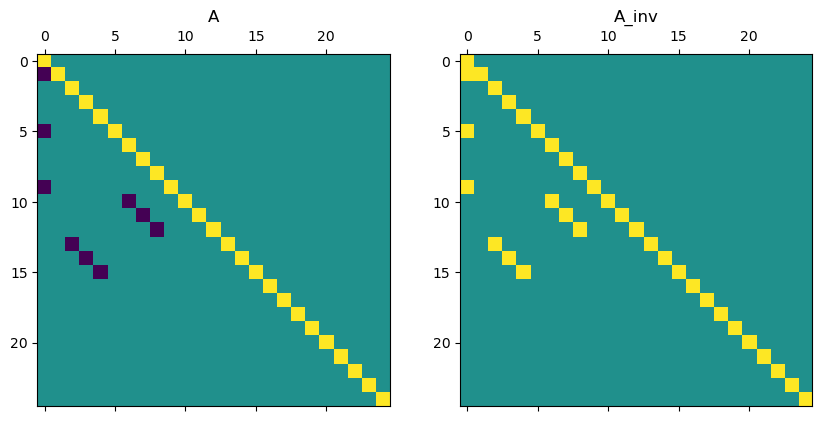

In [8]:
def _get_thinning_matrix(spec_str, encoding_size):

    # Build zeroing-out matrix
    component_dict = {}
    diag_vecs = []
    inv_diag_vecs = []
    diag_offsets = []
    
    # Get specs list
    specs, M = get_shifts_and_sizes(sim_spec_str, encoding_size=encoding_size)
    
    # Add in main diagonal
    diag_vecs.append(M*[1])
    inv_diag_vecs.append(M*[1])
    diag_offsets.append(0)
    for spec in specs:
        key = spec[0]
        m = spec[1]
        offset = spec[2]
        if key not in component_dict:
            component_dict[key] = (m,offset)
        else:
            m1, offset1 = component_dict[key]
            try:
                assert m1==m
            except:
                print('m1:', m1)
                print('m:', m)
                pdb.set_trace()
            diag_vec = offset1*[0]+m*[-1]+(M-(offset+m))*[0]
            inv_diag_vec = offset1*[0]+m*[1]+(M-(offset+m))*[0]
            diag_offset = -(offset-offset1)
            diag_vecs.append(diag_vec)
            inv_diag_vecs.append(inv_diag_vec)
            diag_offsets.append(diag_offset)
    A = sp.diags(diag_vecs, diag_offsets)
    A_inv = sp.diags(inv_diag_vecs, diag_offsets)
    return A, A_inv

fig, axs = plt.subplots(1,2, figsize=[10,5])
A, A_inv = _get_thinning_matrix(sim_spec_str, encoding_size=3)
ax = axs[0]
ax.matshow(A.todense(), vmin=-1, vmax=1)
ax.set_title('A')

ax = axs[1]
ax.matshow(A_inv.todense(), vmin=-1, vmax=1)
ax.set_title('A_inv')

In [9]:
# Copy dictionary, adding a counter
import pdb
def get_x_to_test_thinning_matrix(sim_spec_str):
    """
    input: sim_spec_str
    return: x_test
    """
    # Get shifts and sizes
    specs, M = get_shifts_and_sizes(sim_spec_str, encoding_size=3)

    # Get unique labels
    labels = []
    for spec in specs:
        key = spec[0]
        if not key in labels:
            labels.append(key)

    # Create labels dict
    labels_dict = {}
    counter = 1
    for label in labels:
        labels_dict[label] = .1+.9*counter/len(labels)
        counter +=1 
        
    # Build x_test
    x_test = np.zeros(M)
    for spec in specs:
        key = spec[0]
        m = spec[1]
        offset = spec[2]
        r = labels_dict[key]
        x_test[offset:offset+m]=r
    
    return x_test

.+.+0+.+1+.+1+0+0x1


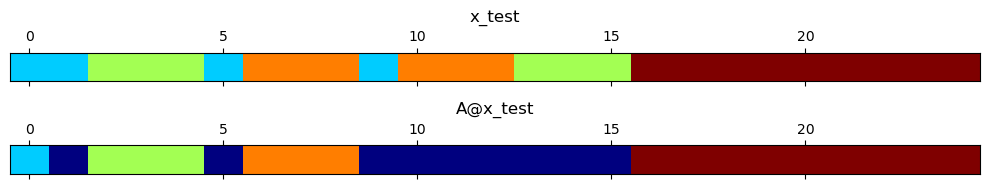

In [10]:
# Test the thinning matrix A

# Get x to test thinning matrix
x_test = get_x_to_test_thinning_matrix(sim_spec_str)

# Make figure
fig, axs = plt.subplots(2,1,figsize=[10,2])

# Show x_test
ax = axs[0]
ax.matshow(x_test.reshape([M,1]).T, vmin=0, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('x_test')
ax.set_aspect('auto')
#ax.colorbar()

# Show A@x_test
ax = axs[1]
ax.matshow((A@x_test).reshape([M,1]).T, vmin=0, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('A@x_test')
ax.set_aspect('auto')
#ax.set_colorbar()

plt.tight_layout()
print(sim_spec_str)

x_ohe.shape: (16,)
M: 16
T.shape: (16, 16)
A.shape: (16, 16)
x_test.shape: (16,)
.+1+0+0x1


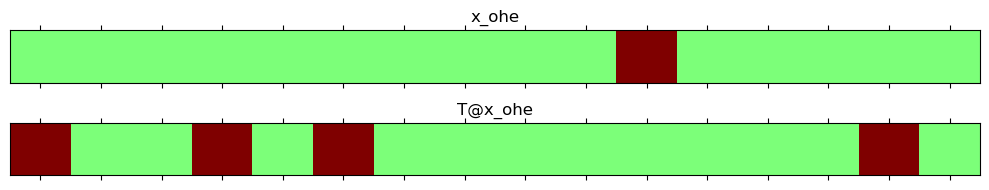

In [39]:
# Test whole peline

# Specify sequence and ohe_spec_str
seq = 'GG'
ohe_spec_str = '0x1'

# Get one-hot encoding of x
x_ohe = seq_to_x(seq, ohe_spec_str)
print(f'x_ohe.shape: {x_ohe.shape}')

M = len(x_ohe)
print(f'M: {M}')

# Get transformation matrix
T, T_inv = _ohe_spec_to_T(ohe_spec_str)
print(f'T.shape: {T.shape}')

# Get sim_spec
sim_spec_str = ohe_to_sim_spec(ohe_spec_str)

# Get thinning matrix
A, A_inv = _get_thinning_matrix(sim_spec_str, encoding_size=3)
print(f'A.shape: {A.shape}')

# Get vector to test thinning matrix
x_test = get_x_to_test_thinning_matrix(sim_spec_str)
print(f'x_test.shape: {x_test.shape}')

# Make figure
fig, axs = plt.subplots(2,1,figsize=[10,2])

# Show x_ohe
ax = axs[0]
ax.matshow(np.mat(x_ohe), vmin=-1, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('x_ohe')
ax.set_aspect('auto')
ax.set_xticks(range(M))
ax.set_xticklabels([])

# Show T@x_ohe
ax = axs[1]
ax.matshow(np.mat(T@x_ohe), vmin=-1, vmax=1, cmap='jet')
ax.set_yticks([])
ax.set_title('T@x_ohe')
ax.set_aspect('auto')
ax.set_xticks(range(M))
ax.set_xticklabels([])

# # Show x_test
# ax = axs[2]
# ax.matshow(np.mat(x_test), vmin=0, vmax=1, cmap='jet')
# ax.set_yticks([])
# ax.set_title('x_test')
# ax.set_aspect('auto')
# ax.set_xticks(range(M))
# ax.set_xticklabels([])

# # Show A@T@x_ohe
# ax = axs[3]
# ax.matshow(np.mat(A@T@x_ohe), vmin=-1, vmax=1, cmap='jet')
# ax.set_yticks([])
# ax.set_title('A@T@x_ohe')
# ax.set_aspect('auto')
# ax.set_xticks(range(M))
# ax.set_xticklabels([])

# # Show A@x_test
# ax = axs[4]
# ax.matshow(np.mat(A@x_test), vmin=0, vmax=1, cmap='jet')
# ax.set_yticks([])
# ax.set_title('A@x_test')
# ax.set_aspect('auto')
# ax.set_xticks(range(M))
# ax.set_xticklabels([])

plt.tight_layout()
print(sim_spec_str)

In [16]:
# The transformed one-hot encoding is not working. Need to verify order-by-order. 

In [ ]:
x.shape

In [ ]:
plt.matshow(T.todense())

In [ ]:
x_ohe = x_ohe_G
x_sim = T_ohe@x_ohe
x_sim

In [ ]:
np.kron(x_sim_A, x_sim_A)

In [ ]:
# Oh fuck. There is another transformation that's needed to decompose factored products. 
# What the hell is going on!? Oh fuck, kronecker products do NOT distribute over direct sums. 
# Well, supposedly they do, but up to some reordering of elements. What is the 
# reordering of the elements, and how do I incorporate this?

In [ ]:
alpha = 4
m = 4
i_vals = list(range(m*alpha))
j_vals = [alpha*i for i in range(m)] + [i-m+1+(i-m)//(alpha-1) for i in range(m,m*alpha)]
data = m*alpha*[1]
B = sp.coo_array((data, (i_vals, j_vals))).todense()

plt.matshow((B.T)@B)

plt.matshow(np.linalg.inv(B))
    